In [1]:
import seaborn as sns, pandas as pd, matplotlib.pyplot as plt, numpy as np, os, datetime
import matplotlib.colors
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
plt.style.use('ggplot')

In [172]:
def add_missing_days(df):
    for year in df.Year.unique():
        for var in df.variable.unique():
            days = df.loc[(df.Year==year)&(df.variable==var),"Day"]
            missing_days = list(set(range(1,366)).difference(set(days)))
            _df = pd.DataFrame(data={"Year": [year]*len(missing_days),"Day": missing_days, "variable": [var]*len(missing_days), "value": np.nan})
            df = pd.concat([df,_df])
    return df

In [176]:
def doy(s):
    '''Returns day of year'''
    fmt = '%Y-%m-%d'
    dt = datetime.datetime.strptime(s, fmt)
    tt = dt.timetuple()
    return tt.tm_yday

def plotenv(env):
    '''Plots environmental panels'''
    ## Extract day of year
    days = [doy(str(s)[0:10]) for s in env.SampleID]
    ## Extract year
    y = [str(x)[0:4] for x in env.SampleID]
    ## Set ticks
    month_ticks = [1,32,60,91,121,152,182,213,244,274,305,335]
    month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    ## Define variables
    var = ["Temperature","Salinity","Chla","Nitrate","Phosphate","Silicate","Ammonium","DOC","TotalN","BacterialAbundance"]
    ## Extract columns
    e = env.loc[:,var]
    ## Add day and year info
    e["Day"] = days
    e["Year"] = y
    ## Melt
    e = pd.melt(e,id_vars=["Year","Day"])
    ## Remove DOC outliers
    e.loc[(e.variable=="DOC") & (e.value>=450),"value"] = np.nan
    ## Add missing days
    e = add_missing_days(e)
    
    ## Create facetgrid
    g = sns.FacetGrid(e, col="variable", hue="Year", col_wrap=5, size=3, sharey=False, legend_out=True)
    g = (g.map(plt.plot, "Day", "value", linewidth=1, marker="o", ms=3).add_legend())
    g.set(xticks=month_ticks,xticklabels=month_labels)
    g.set_xticklabels(rotation=90)
    g.set_titles("{col_name}")
    return e

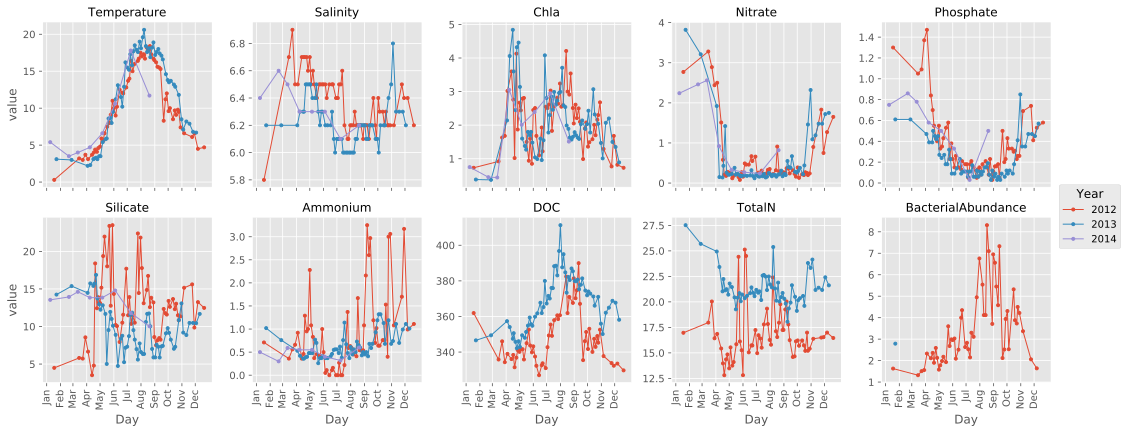

In [178]:
env = pd.read_csv("data/LMO.time.series.metadata.csv", header=0, sep="\t", parse_dates=["SampleID"])
env = env.loc[env.Year.isin([2012.0,2013.0,2014.0])]
e = plotenv(env)
plt.savefig("results/figures/environmental_profile.png", bbox_to_inches="tight", dpi=300)